The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


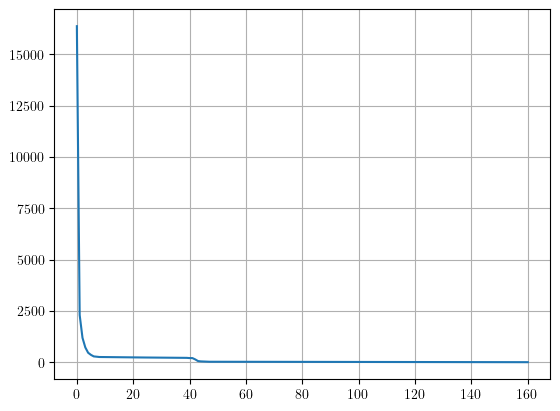

In [51]:
"""DMD with Control vs Deep Recurrent Koopman (DeReK) comparison for non-linear systems"""

import os
import sys
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp

# Add parent directory to path
sys.path.append(os.path.dirname(os.getcwd()))

from functions.dmd import DMDc  # noqa: E402
from functions.preprocessing import time_shift  # noqa: E402

%load_ext autoreload
%autoreload 2

# Set random seed for reproducibility
np.random.seed(42)

# Define your line styles
line_styles = [
    "-",
    "--",
    "-.",
    ":",
    (0, (3, 1, 1, 1)),
    (0, (5, 5)),
    (0, (3, 5, 1, 5)),
    (0, (3, 10, 1, 10)),
    (0, (5, 1)),
    (0, (5, 10)),
]

# Combine default color cycle with the line styles
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
line_cycler = plt.cycler("color", colors) + plt.cycler(
    "linestyle", line_styles
)

# Apply the combined cycler to the axes
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "CMU Serif",
        "font.serif": "CMU Serif",
        "axes.prop_cycle": line_cycler,
        "axes.grid": True,
    }
)


def set_size(
    width: float
    | int
    | Literal["article", "ieee", "thesis", "beamer"] = 307.28987,
    fraction=1.0,
    subplots=(1, 1),
):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the height which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == "article":
        width_pt = 390.0
    elif width == "ieee":
        width_pt = 252.0
    elif width == "thesis":
        width_pt = 426.79135
    elif width == "beamer":
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**0.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = (
        fig_width_in * golden_ratio * ((subplots[0] * fraction) / subplots[1])
    )

    return (fig_width_in * 1.2, fig_height_in * 1.2)


part = 1000

results_path = "results/.dmdc/"
if not os.path.exists(results_path):
    os.makedirs(results_path)


def mae(Y: np.ndarray, Y_pred: np.ndarray) -> np.ndarray:
    return np.mean(np.abs(Y - Y_pred), axis=0)


def sad(Y: np.ndarray, Y_pred: np.ndarray) -> np.ndarray:
    return np.sum(np.abs(Y - Y_pred), axis=0)


# Set preprocessing parameters
residuals = False
sqrt = True
degree = 2
hm = 20
hl = 0
p = 0
q = 0
# Import train data
train_data = pd.read_pickle("data/train_sim.pkl")
# noise = np.zeros(train_data["X"].shape)
X: np.ndarray = (train_data["X"])[:-1]
U: np.ndarray = train_data["U"][:-1]
# We want Y_k to be X_{k+1}
Y: np.ndarray = (train_data["Y"])[1:]
n, m = X.shape
# Import test data
test_data = pd.read_pickle("data/test_sim.pkl")
X_t: np.ndarray = (test_data["X"])[:-1]
U_t: np.ndarray = test_data["U"][:-1]
Y_t: np.ndarray = (test_data["Y"])[1:]
# Import DeReK results
data_derek = sp.io.loadmat("../results/pred_sim_DeReK.mat")
data_derek = sp.io.loadmat("../results/pred_sim_DeReK.mat")
start = 80
Y_pred_derek = np.row_stack((data_derek["h1"], data_derek["h2"])).T[
    : part - hm
]
data_edmdc_wo_sqrt = sp.io.loadmat("results/pred_sim_eDMDc_wo_sqrt.mat")
Y_pred_edmdc_wo_sqrt = np.row_stack(
    (data_edmdc_wo_sqrt["h1"], data_edmdc_wo_sqrt["h2"])
).T

# Extract non-linear features
basis_functions = [
    lambda x: np.sqrt(x),
    lambda x: x**2,
    lambda x: x**3,
    lambda x: x,
]
inv_basis_functions = [
    lambda x: x**2,
    lambda x: np.sqrt(x),
    lambda x: x ** (1 / 3),
    lambda x: x,
]
X = np.hstack([f(X) for f in basis_functions])
# Extract time-delayed features
X = time_shift(X, hm)
U = U[:-hm]
Y = Y[:-hm]

X_t = np.hstack([f(X_t) for f in basis_functions])
X_t = time_shift(X_t, hm)[start : start + part]
U_t = U_t[start : start + part - hm]
Y_t = Y_t[start : start + part - hm]

# Set parameters
pred_step = len(Y_t)

# Train DMD model
model = DMDc(p=p, q=q)
model.fit(X, U=U)

In [44]:
Y_pred = model.predict(X[0, :], U=U, forecast=len(Y))
stats_ = {
    "MAE": [],
    "SAD": [],
}
for j in range(0, hm * len(basis_functions), m * len(basis_functions)):
    for i, fun in enumerate(inv_basis_functions):
        start_col = i * m + j
        end_col = (i + 1) * m + j
        Y_pred[:, start_col:end_col] = fun(Y_pred[:, start_col:end_col])
        stats_["MAE"].append(mae(Y, Y_pred[:, start_col:end_col]).sum())
        stats_["SAD"].append(sad(Y, Y_pred[:, start_col:end_col]).sum())

/var/folders/zw/bktnb4fx24l0wfdggx3jv71m0000gn/T/ipykernel_53241/1562896917.py:171: RuntimeWarning: invalid value encountered in sqrt
  lambda x: np.sqrt(x),
/var/folders/zw/bktnb4fx24l0wfdggx3jv71m0000gn/T/ipykernel_53241/1562896917.py:172: RuntimeWarning: invalid value encountered in power
  lambda x: x ** (1 / 3),


In [45]:
# Index of best matching transformation to original data
best_idx = stats_["MAE"].index(min(stats_["MAE"]))
best_idx

0

In [46]:
Y_pred = model.predict(X_t[0, :], U=U_t, forecast=pred_step)
for j in range(0, hm * len(basis_functions), m * len(basis_functions)):
    for i, fun in enumerate(inv_basis_functions):
        start_col = i * m + j
        end_col = (i + 1) * m + j
        Y_pred[:, start_col:end_col] = fun(Y_pred[:, start_col:end_col])

/var/folders/zw/bktnb4fx24l0wfdggx3jv71m0000gn/T/ipykernel_53241/1562896917.py:171: RuntimeWarning: invalid value encountered in sqrt
  lambda x: np.sqrt(x),
/var/folders/zw/bktnb4fx24l0wfdggx3jv71m0000gn/T/ipykernel_53241/1562896917.py:172: RuntimeWarning: invalid value encountered in power
  lambda x: x ** (1 / 3),


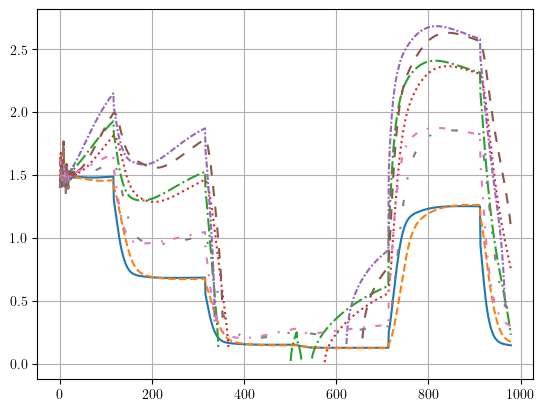

In [47]:
plt.plot(Y_pred[:, : m * len(basis_functions)])

Model | MAE | SAD
DMDc | 0.1737 | 170.24
eDMDc without sqrt | 0.6058 | 593.7
DeReK | 0.2005 | 196.51


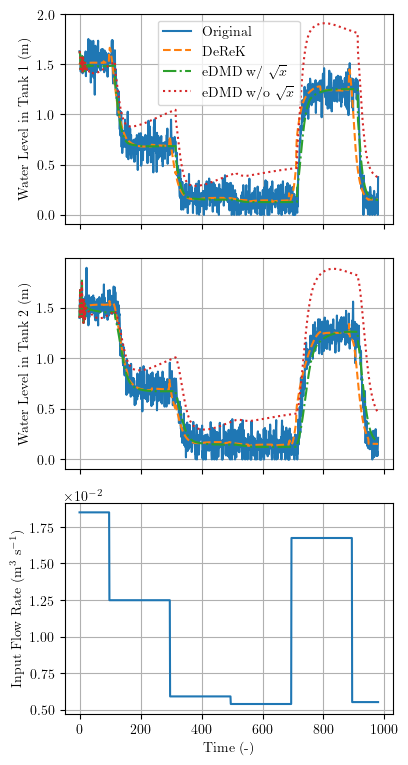

In [58]:
# Perform DMD as multi-step ahead prediction
# Y_pred = model.predict(X_t[0, :], U=U_t, forecast=pred_step)
Y_pred = Y_pred[:, best_idx * m : (best_idx + 1) * m]

# Print MAE and SAD
print("Model | MAE | SAD")
mae_ = mae(Y_t, Y_pred)
sad_ = sad(Y_t, Y_pred)
print("DMDc |", mae_.sum().round(4), "|", sad_.sum().round(2))
mae_ = mae(Y_t, Y_pred_edmdc_wo_sqrt)
sad_ = sad(Y_t, Y_pred_edmdc_wo_sqrt)
print("eDMDc without sqrt |", mae_.sum().round(4), "|", sad_.sum().round(2))
mae_ = mae(Y_t, Y_pred_derek)
sad_ = sad(Y_t, Y_pred_derek)
print("DeReK |", mae_.sum().round(4), "|", sad_.sum().round(2))

# Plot results
fig, axs = plt.subplots(
    3, 1, figsize=set_size("ieee", subplots=(3, 1)), sharex=True
)
if not isinstance(axs, np.ndarray):
    axs = np.array([axs])

for i, (ax, y_t, y_derek, y_pred, y_pred_wo_sqrt) in enumerate(
    zip(
        axs,
        Y_t.T,
        Y_pred_derek.T,
        Y_pred.T,
        Y_pred_edmdc_wo_sqrt.T,
    ),
    start=1,
):
    ax.plot(y_t)
    ax.plot(y_derek)
    ax.plot(y_pred)
    ax.plot(y_pred_wo_sqrt)
    ax.set_ylabel(f"Water Level in Tank {i} " + "$\\mathrm{(m)}$")
    ax.ticklabel_format(style="sci", axis="y", scilimits=(2, 1))

axs[2].plot(U_t[:, -1])
axs[2].set_ylabel("Input Flow Rate $\\mathrm{(m^3~s^{-1})}$")
axs[2].set_xlabel("Time (-)")
axs[2].ticklabel_format(style="sci", axis="y", scilimits=(2, 1))

axs[0].legend(
    [
        "Original",
        "DeReK",
        "eDMD w/ $\\sqrt{x}$",
        "eDMD w/o $\\sqrt{x}$",
    ]
)

fig.tight_layout()
fig.savefig(f"{results_path}dmdc_multipred-p{p}-q{q}-hm{hm}-hl{hl}.pdf")

In [38]:
# compute Koopman eigenvalues and eigenvectors
eig, eig_vec = np.linalg.eig(model.A)
# Koopman eigenvalues real and imaginary parts
eReal = eig.real
eImag = eig.imag
# unit circle
t = np.linspace(0.0, 2 * np.pi, 1000)
x_circ = np.cos(t)
y_circ = np.sin(t)

Text(0.5, 0.98, 'Koopman operator eigenvalues')

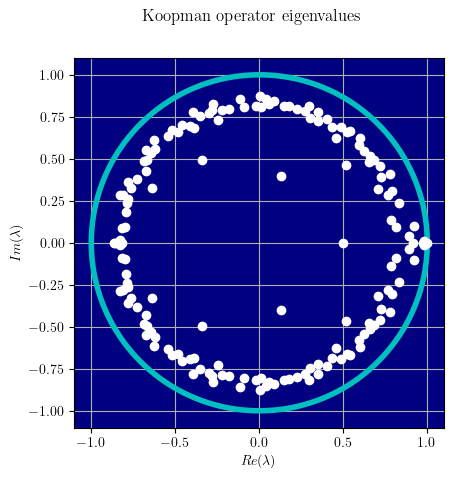

In [39]:
# plot Koopman eigenvalues
fig1, ax1 = plt.subplots()
ax1.plot(x_circ, y_circ, "c", linewidth=4)
ax1.plot(eReal, eImag, "wo")
ax1.set_aspect("equal", "box")
ax1.set_facecolor("navy")
ax1.set_xlabel("$Re(\\lambda)$")
ax1.set_ylabel("$Im(\\lambda)$")
fig1.suptitle("Koopman operator eigenvalues")

In [40]:
sp.io.savemat(
    "results/pred_sim_eDMDc_w_sqrt.mat", dict(zip(["h1", "h2"], Y_pred.T))
)